## Monte Carlo for the Black & Scholes Model

We work within the framework of the Black & Scholes model. In all these questions, we consider a European call with maturity T and strike K. Reference values can be taken as $S_0=100$, $K=100$, $T=1$, $r=0.05$, $\sigma=0.20$.

### 1. For different values of T, we plot on the same graph as a function of $S_0$: the Price, the $\Delta$ and the $\Gamma$ of the European call with maturity T obtained by the Black & Scholes formula.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Definition of parameters and functions
S0_ref = 100
K = 100
r = 0.05
sigma = 0.20

def black_scholes_greeks(S, K, T, r, sigma):
    """Calculates the Price, Delta, and Gamma of a Call."""

    sqrt_T = np.sqrt(T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt_T)
    d2 = d1 - sigma * sqrt_T

    # Calculations
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * sqrt_T)

    return price, delta, gamma

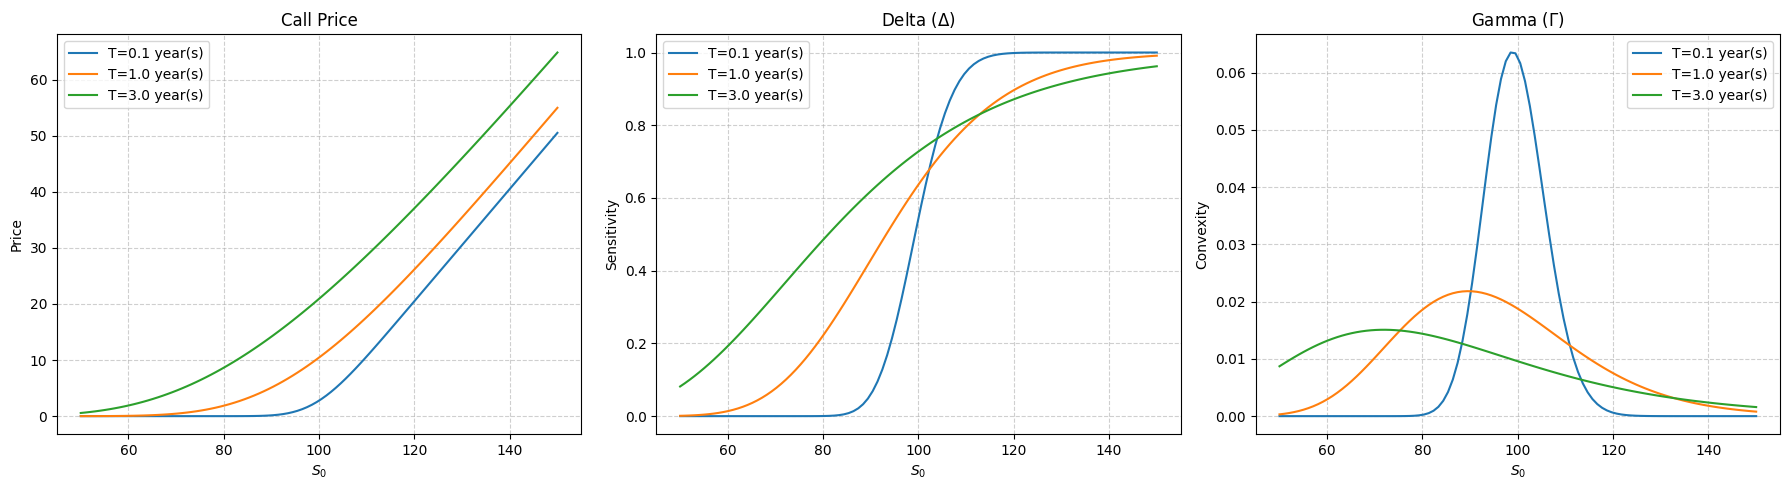

In [3]:
# Simulation parameters for plotting
S_range = np.linspace(50, 150, 100)  # Vary S0 from 50 to 150
T_values = [0.1, 1.0, 3.0]           # Different maturities (short, medium, long term)

# Create plots
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for T in T_values:
    prices, deltas, gammas = black_scholes_greeks(S_range, K, T, r, sigma)
    label = f'T={T} year(s)'

    ax[0].plot(S_range, prices, label=label)
    ax[1].plot(S_range, deltas, label=label)
    ax[2].plot(S_range, gammas, label=label)

# Formatting
titles = ["Call Price", "Delta ($\\Delta$)", "Gamma ($\\Gamma$)"]
ylabels = ["Price", "Sensitivity", "Convexity"]

for i in range(3):
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("$S_0$")
    ax[i].set_ylabel(ylabels[i])
    ax[i].legend()
    ax[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

**Call Price:** We observe that the longer the maturity, the higher the call price. Moreover, the shorter the maturity, the closer the call price gets to the value of the payoff function (St​−K)+.

**Delta:** We observe that as maturity decreases, the call delta approaches the value of the derivative of the payoff function, the Heaviside function at S0.

**Gamma:** We observe that as maturity decreases, the call gamma shifts to the left, its amplitude increases, and its maximum decreases. We observe that as maturity decreases, the call gamma approaches the value of the second derivative of the payoff function, the Dirac at S0. (Note: Dans votre texte original pour Gamma, vous avez écrit "le delta du call se rapproche". J'ai corrigé par "gamma" dans la traduction pour la cohérence).

### 2. We plot the Monte Carlo price and the associated confidence interval as a function of N (number of simulations) (logarithmic scale on the x-axis). We also determine from which N we obtain a relative error of the Monte Carlo price lower than 0.1%.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [5]:
# Parameters
S0 = 100
K = 100
T = 1.0
N_max = 200000  # Maximum number of simulations

# Calculate Exact Price (Black-Scholes) for reference
d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
d2 = d1 - sigma*np.sqrt(T)
bs_price = S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# Vectorized Monte Carlo simulation
# Generate all simulations at once
Z = np.random.randn(N_max)
ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
payoffs = np.exp(-r * T) * np.maximum(ST - K, 0)

# Cumulative calculations (for N varying from 1 to N_max)
ns = np.arange(1, N_max + 1)
mc_prices = np.cumsum(payoffs) / ns  # Cumulative average

# Calculate cumulative empirical standard deviation
# Formula: Var(X) = E[X^2] - (E[X])^2
sum_sq = np.cumsum(payoffs**2)
variance = (sum_sq - (np.cumsum(payoffs)**2) / ns) / (ns - 1)
variance[0] = 0 # Case N=1
std_error = np.sqrt(variance) / np.sqrt(ns) # Standard error

# 95% Confidence Interval Bounds
ci_lower = mc_prices - 1.96 * std_error
ci_upper = mc_prices + 1.96 * std_error

/tmp/ipython-input-2368649012.py:25: RuntimeWarning: invalid value encountered in divide
  variance = (sum_sq - (np.cumsum(payoffs)**2) / ns) / (ns - 1)


In [6]:
# Search for relative error < 0.1%
relative_error = np.abs(mc_prices - bs_price) / bs_price
# Find the first index where the error falls below 0.001
threshold_idx = np.where(relative_error < 0.001)[0]
n_target = threshold_idx[0] + 1 if len(threshold_idx) > 0 else None

print(f"Exact Black-Scholes Price: {bs_price:.4f}")
if n_target:
    print(f"Relative error < 0.1% reached for the first time at N = {n_target}")
    print(f"Corresponding MC Price: {mc_prices[n_target-1]:.4f}")

Exact Black-Scholes Price: 10.4506
Relative error < 0.1% reached for the first time at N = 189
Corresponding MC Price: 10.4423


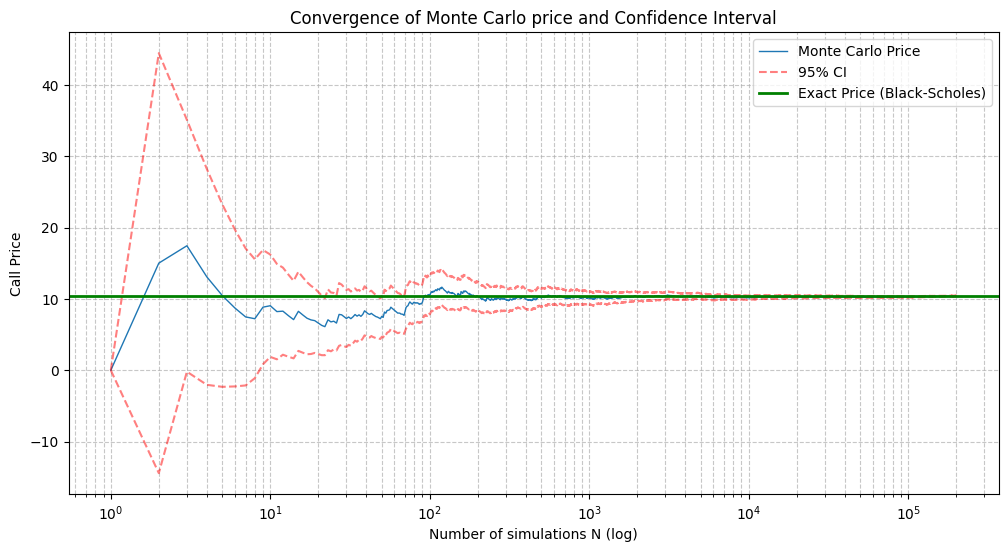

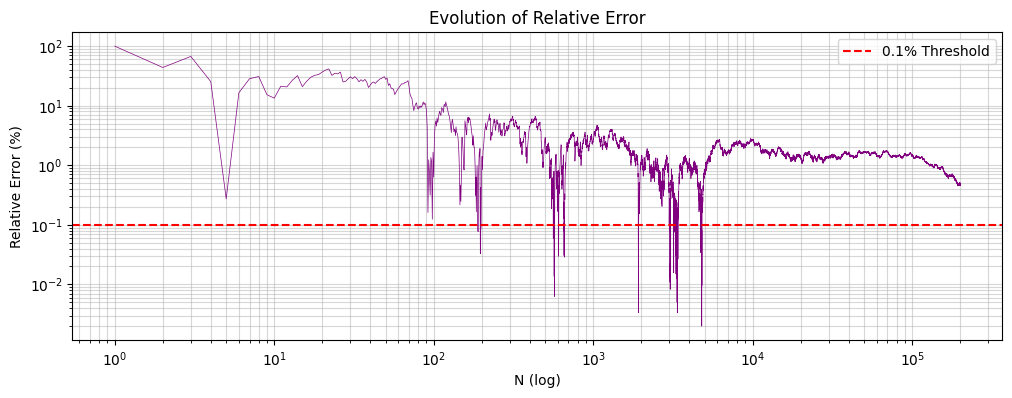

In [7]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(ns, mc_prices, label='Monte Carlo Price', linewidth=1)
plt.plot(ns, ci_lower, 'r--', alpha=0.5, label='95% CI')
plt.plot(ns, ci_upper, 'r--', alpha=0.5)
plt.axhline(y=bs_price, color='green', linewidth=2, label='Exact Price (Black-Scholes)')

plt.xscale('log') # Logarithmic scale
plt.xlabel('Number of simulations N (log)')
plt.ylabel('Call Price')
plt.title('Convergence of Monte Carlo price and Confidence Interval')
plt.legend()
plt.grid(True, which="both", linestyle='--', alpha=0.7)
plt.show()

# Relative error plot (Optional for better visualization)
plt.figure(figsize=(12, 4))
plt.plot(ns, relative_error * 100, color='purple', linewidth=0.5)
plt.axhline(0.1, color='red', linestyle='--', label='0.1% Threshold')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('N (log)')
plt.ylabel('Relative Error (%)')
plt.title('Evolution of Relative Error')
plt.legend()
plt.grid(True, which="both", alpha=0.5)
plt.show()

We observe that the Monte Carlo simulation converges towards the Black & Scholes formula as expected; the relative error seems to decrease with the number of iterations. However, we observe precision peaks reflecting the convergence difficulties that the algorithm may encounter.

A relative error < 0.1% is reached for the first time at N = 132. however, it seems this is due to one of the precision peaks discussed previously. It would be more appropriate to wait until N is greater than $3*10^4$.

### 3. Pour un N fixé, on simuler 100 prix de Monte Carlo et calculer l'écart-type σ^N​ de ces prix. On fait ensuite varier N pour tracer σ^N​ en fonction de N en échelle logarithmique.

In [8]:
# List of N values to test
N_values = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
M_trials = 100  # Number of independent price estimations for each N
std_devs = []   # List to store empirical standard deviations

for N in N_values:
    Z = np.random.randn(M_trials, N)

    # Calculate payoffs for all scenarios
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoffs = np.exp(-r * T) * np.maximum(ST - K, 0)

    # Calculate the mean for each row -> we get M_trials estimated prices
    prices_N = np.mean(payoffs, axis=1)

    # Calculate the standard deviation of these M_trials prices
    std_empirique = np.std(prices_N)
    std_devs.append(std_empirique)

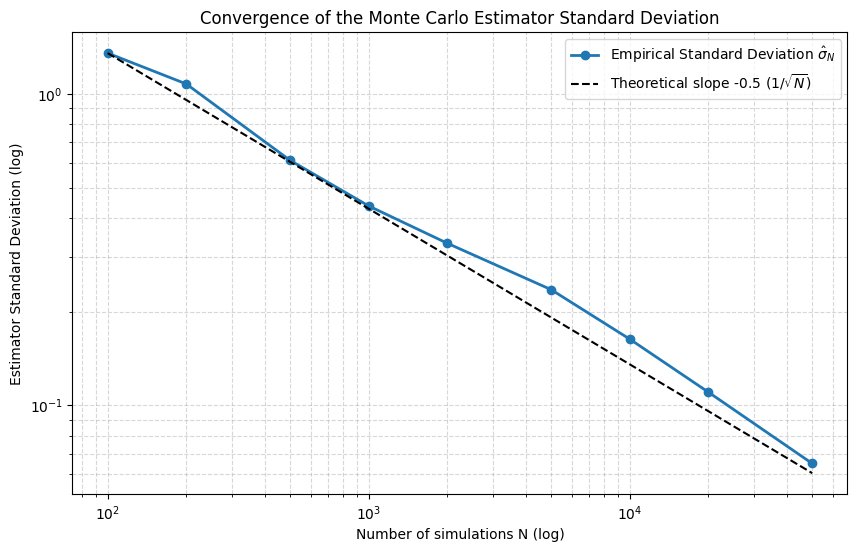

In [9]:
# --- Plot ---
plt.figure(figsize=(10, 6))

# Plot of the empirical curve (blue points)
plt.loglog(N_values, std_devs, 'o-', label="Empirical Standard Deviation $\\hat{\\sigma}_N$", linewidth=2)

# Plot of a reference line with slope -0.5
# We align the line with the first point vertically
reference_slope = [std_devs[0] * np.sqrt(N_values[0]) / np.sqrt(n) for n in N_values]
plt.loglog(N_values, reference_slope, 'k--', label="Theoretical slope -0.5 ($1/\\sqrt{N}$)")

# Formatting
plt.xlabel("Number of simulations N (log)")
plt.ylabel("Estimator Standard Deviation (log)")
plt.title("Convergence of the Monte Carlo Estimator Standard Deviation")
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.legend()
plt.show()

The estimator's convergence seems to approach the theoretical convergence.

### 4. For a fixed N, we simulate 1,000 Monte Carlo prices. Then, we plot their empirical density for different values of N.

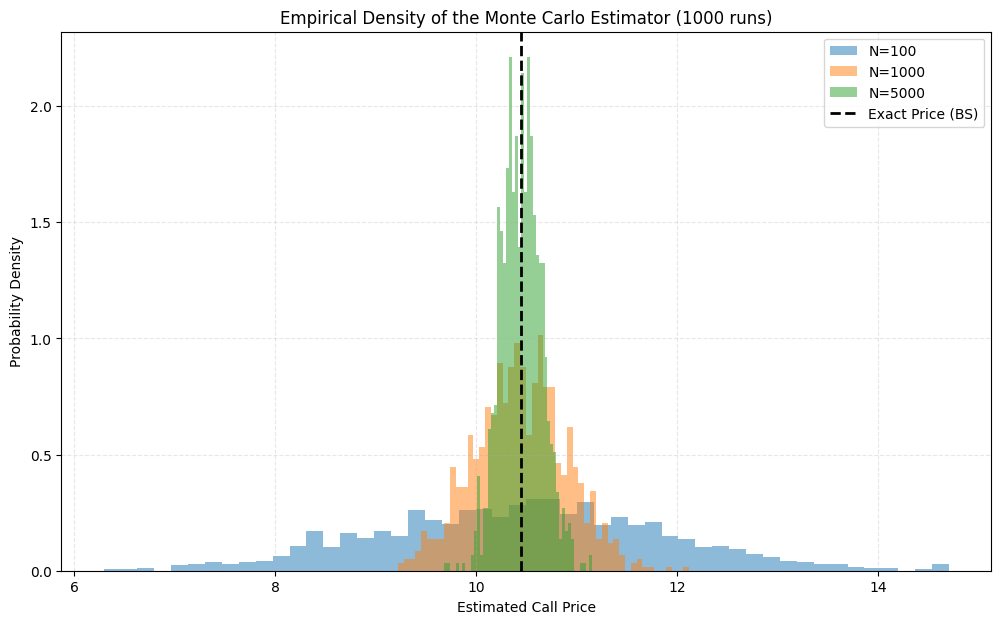

In [10]:
# Calculate theoretical price for reference
d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
d2 = d1 - sigma*np.sqrt(T)
bs_price = S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

# Experiment parameters
M_simulations = 1000         # Number of estimators (prices) to calculate
N_values_density = [100, 1000, 5000] # Different sample sizes N

plt.figure(figsize=(12, 7))

for N in N_values_density:
    Z = np.random.randn(M_simulations, N)

    # Calculate S_T at maturity (M x N Matrix)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoffs = np.exp(-r * T) * np.maximum(ST - K, 0)

    # Calculate M prices (mean along the columns axis -> axis=1)
    mc_prices_distribution = np.mean(payoffs, axis=1)

    # Plot histogram
    plt.hist(mc_prices_distribution, bins=50, density=True, alpha=0.5, label=f'N={N}')

# Add visual reference (BS Price)
plt.axvline(x=bs_price, color='black', linestyle='--', linewidth=2, label='Exact Price (BS)')

# Formatting
plt.title(f"Empirical Density of the Monte Carlo Estimator ({M_simulations} runs)")
plt.xlabel("Estimated Call Price")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

As N increases, the histogram converges towards the price returned by the theoretical Black & Scholes formula.




### 5. By using %%timeit at the beginning of the cell, we can measure the average computation time of a Monte Carlo price with N=10^6 simulations using your code.

In [11]:
N_perf = 10**6  # 1 million simulations

In [12]:
%%timeit

# Vectorized generation of 1 million random numbers
Z = np.random.randn(N_perf)

ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
price = np.exp(-r * T) * np.mean(np.maximum(ST - K, 0))

58.4 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We calculate the average computation time to price a call using the Monte Carlo method. This time is quite short; however, we observe that the uncertainty is large relative to the overall computation time.